In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import natsort
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
warnings.filterwarnings('ignore')

# Define constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH*3

In [2]:
di1 = "./graduation_dataset/final_data/7. mask_round_vs_rectangle/train/"

filenames = os.listdir(di1)

categories = []

for filename in filenames:
    category = filename.split('_')[0]
    if category == 'round':
        categories.append(0)
    else :
        categories.append(1)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,rectangle_000.png,1
1,rectangle_001.png,1
2,rectangle_002.png,1
3,rectangle_003.png,1
4,rectangle_004.png,1


In [3]:
df.tail()

,filename,category
227,round_107.jpg,0
228,round_108.jpg,0
229,round_109.jpg,0
230,round_110.jpg,0
231,round_111.jpg,0


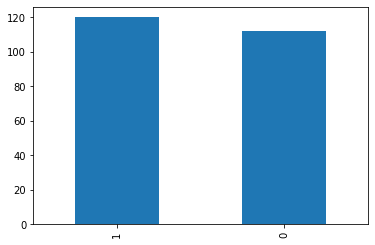

In [4]:
df['category'].value_counts().plot.bar()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [6]:
df["category"] = df["category"].replace({0: 'round', 1: 'rectangle'})

In [7]:
df.head()

,filename,category
0,rectangle_000.png,rectangle
1,rectangle_001.png,rectangle
2,rectangle_002.png,rectangle
3,rectangle_003.png,rectangle
4,rectangle_004.png,rectangle


In [8]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

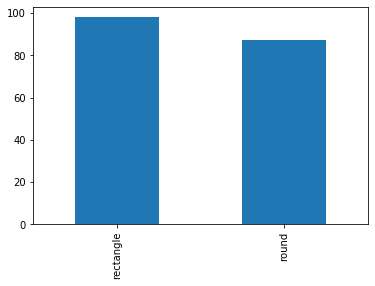

In [9]:
train_df['category'].value_counts().plot.bar()

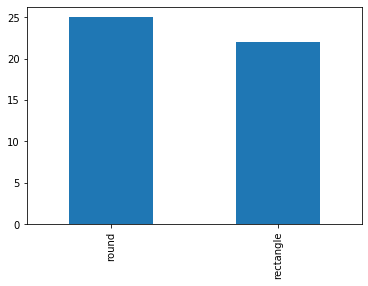

In [10]:
validate_df['category'].value_counts().plot.bar()

In [11]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=5

In [12]:
#Train Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
     train_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)

Found 185 validated image filenames belonging to 2 classes.


In [13]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)


Found 47 validated image filenames belonging to 2 classes.


In [14]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


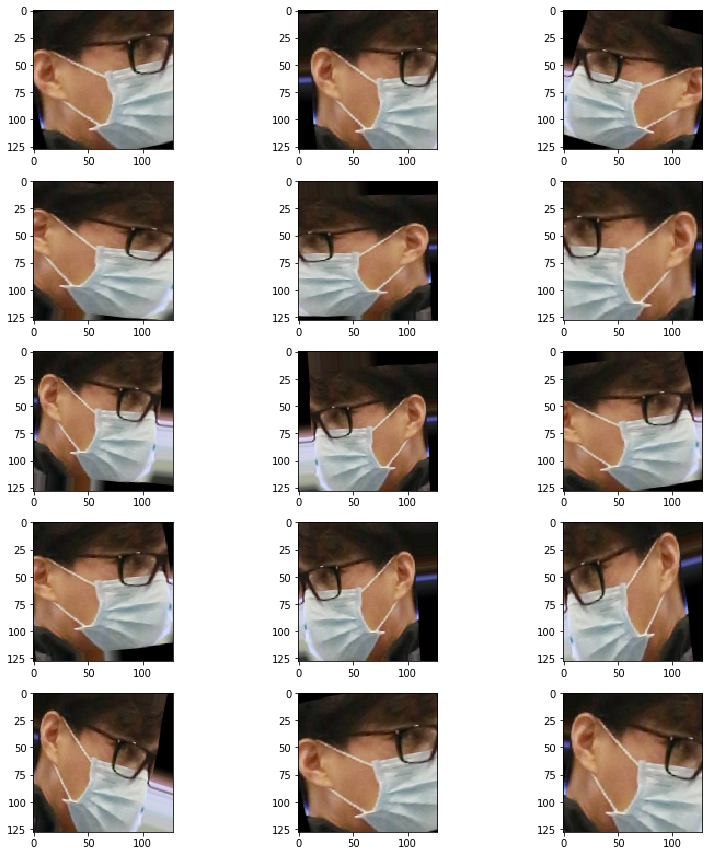

In [15]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [16]:
# Fit model
epochs = 3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps= total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
37/37 [==============================] - 11s 300ms/step - loss: 1.0280 - accuracy: 0.5081 - val_loss: 0.6930 - val_accuracy: 0.4889
Epoch 2/50
37/37 [==============================] - 11s 294ms/step - loss: 0.6812 - accuracy: 0.6054 - val_loss: 0.6921 - val_accuracy: 0.5333
Epoch 3/50
37/37 [==============================] - 11s 299ms/step - loss: 0.6771 - accuracy: 0.5676 - val_loss: 0.6918 - val_accuracy: 0.4667
Epoch 4/50
37/37 [==============================] - 13s 342ms/step - loss: 0.6704 - accuracy: 0.5730 - val_loss: 0.6896 - val_accuracy: 0.5556
Epoch 5/50
37/37 [==============================] - 13s 353ms/step - loss: 0.6494 - accuracy: 0.6432 - val_loss: 0.6853 - val_accuracy: 0.6222
Epoch 6/50
37/37 [==============================] - 12s 318ms/step - loss: 0.6282 - accuracy: 0.6649 - val_loss: 0.6864 - val_accuracy: 0.6444
Epoch 7/50
37/37 [==============================] - 12s 331ms/step

In [17]:
model.save_weights("mask_round_rectangle_model_final.h5")

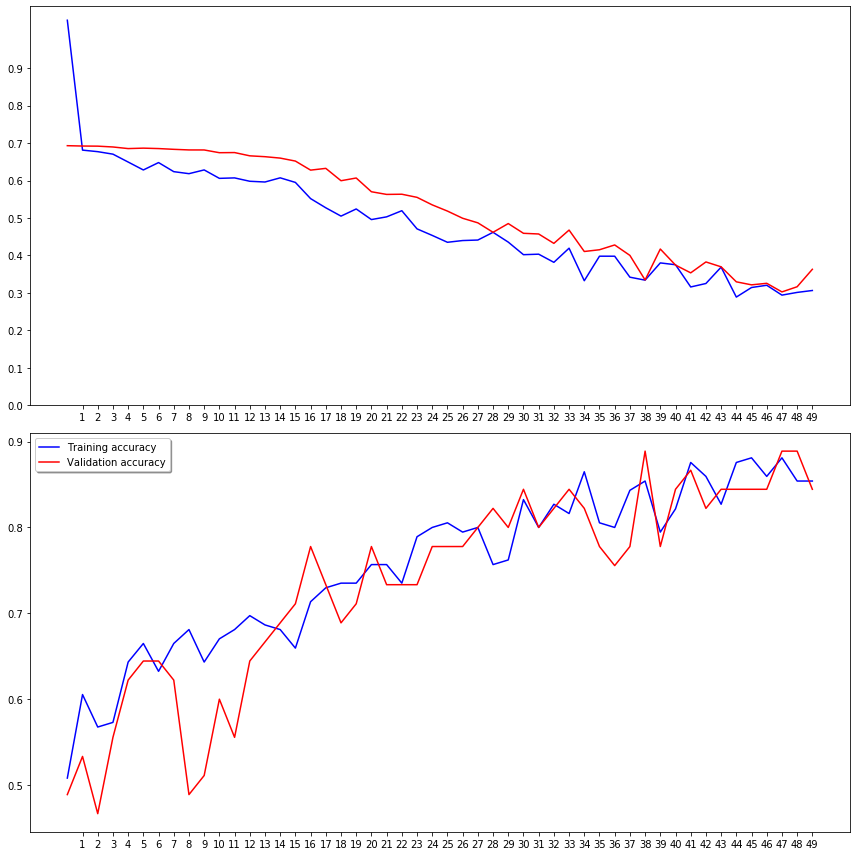

In [18]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()